In [7]:
import numpy as np
import gymnasium as gym
import gym_trading_env
import matplotlib.pyplot as plt
import logging
import tensorflow as tf
import yfinance as yf

from src.agent import DoubleQLearningAgent
from src.learner import q_learning_learning_loop
from src.replay import PrioritizedReplayBuffer
from src.environment import make_env
from src.utils import save_pickle, load_pickle, plot_grid, run_learned_policy

# Set up logging and GPU/CPU configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    device = '/GPU:0'
    logging.info("Using GPU for training")
else:
    device = '/CPU:0'
    logging.info("Using CPU for training")

2024-06-26 16:08:16,562 - INFO - Using GPU for training


In [ ]:
def fetch_stock_data(symbol, start_date, end_date, output_file):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data['Close'] = stock_data['Adj Close']
    
    stock_data = stock_data.drop(columns=['Adj Close'])

    # Convert column headers to lowercase
    stock_data.columns = stock_data.columns.str.lower()

    stock_data.to_csv(output_file)
        
    return stock_data

stock_data = fetch_stock_data('AAPL', '2019-06-20', '2024-06-21', 'AAPL_data.csv')

### Q-Learning

#### Environment Setup

In [2]:
num_envs = 3
file_path = 'AAPL_data.csv'
envs = gym.vector.SyncVectorEnv([lambda: make_env(file_path, number_of_days_to_consider=20, n_select=15) for _ in range(num_envs)])

DataFrame head before adding optimal TA features:
                 open       high        low      close     volume
date                                                             
2019-06-20  50.092499  50.152500  49.507500  49.865002   86056000
2019-06-21  49.700001  50.212502  49.537498  49.695000  191202400
2019-06-24  49.634998  50.040001  49.542500  49.645000   72881600
2019-06-25  49.607498  49.814999  48.822498  48.892502   84281200
2019-06-26  49.442501  50.247501  49.337502  49.950001  104270000
Shape of DataFrame before adding indicators: (1259, 5)
Shape of DataFrame after adding indicators: (1259, 20)
Selected 15 optimal features: ['BOP', 'STOCHRSI_k', 'STOCHF_k', 'TRANGE', 'WILLR', 'STOCHRSI_d', 'ATR', 'MOM', 'NATR', 'RSI', 'CMO', 'CCI', 'MINUS_DM', 'STOCH_k', 'STOCHF_d']
Columns after adding optimal technical indicators: Index(['open', 'high', 'low', 'close', 'volume', 'BOP', 'STOCHRSI_k',
       'STOCHF_k', 'TRANGE', 'WILLR', 'STOCHRSI_d', 'ATR', 'MOM', 'NATR',
       '

#### Agent Initialization

In [3]:
buffer_size = 10000
batch_size = 32
agent = DoubleQLearningAgent(
    envs, 
    learning_rate=0.001, 
    discount_factor=0.95,
    buffer_size=buffer_size,
    batch_size=batch_size
)

#### Training

Market Return : 320.50%   |   Portfolio Return :  0.41%   |   Position Changes : 832   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : -50.51%   |   Position Changes : 819   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : -31.62%   |   Position Changes : 828   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : -15.38%   |   Position Changes : 835   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 99.44%   |   Position Changes : 830   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : -6.05%   |   Position Changes : 853   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : -16.94%   |   Position Changes : 839   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : -49.26%   |   Position Changes : 844   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portf

2024-06-26 14:57:26,114 - INFO - Episode 100/10000 - Mean Reward: 0.5443196880666644 - Epsilon: 0.9549925860214323


Market Return : 320.50%   |   Portfolio Return : 42.40%   |   Position Changes : 707   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 115.69%   |   Position Changes : 709   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 66.67%   |   Position Changes : 718   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : -33.72%   |   Position Changes : 703   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : -37.83%   |   Position Changes : 710   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 191.93%   |   Position Changes : 706   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 205.85%   |   Position Changes : 709   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 113.63%   |   Position Changes : 739   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Port

2024-06-26 14:58:01,069 - INFO - Episode 200/10000 - Mean Reward: 1.0403505458149638 - Epsilon: 0.9120108393559037


Market Return : 320.50%   |   Portfolio Return : 258.33%   |   Position Changes : 475   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 93.91%   |   Position Changes : 517   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 226.26%   |   Position Changes : 502   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 325.09%   |   Position Changes : 498   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 124.17%   |   Position Changes : 490   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 514.48%   |   Position Changes : 497   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 213.72%   |   Position Changes : 544   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 69.40%   |   Position Changes : 473   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Port

2024-06-26 14:58:36,310 - INFO - Episode 300/10000 - Mean Reward: 1.2169486445210624 - Epsilon: 0.870963589956072


Market Return : 320.50%   |   Portfolio Return : 452.36%   |   Position Changes : 316   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 152.97%   |   Position Changes : 311   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 175.58%   |   Position Changes : 335   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 110.42%   |   Position Changes : 324   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 134.28%   |   Position Changes : 373   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 235.38%   |   Position Changes : 320   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 736.46%   |   Position Changes : 312   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 157.54%   |   Position Changes : 327   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Po

2024-06-26 14:59:10,891 - INFO - Episode 400/10000 - Mean Reward: 0.8637832660543818 - Epsilon: 0.8317637711026604


Market Return : 320.50%   |   Portfolio Return : 106.69%   |   Position Changes : 368   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 136.95%   |   Position Changes : 399   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 172.54%   |   Position Changes : 385   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 129.09%   |   Position Changes : 193   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 117.99%   |   Position Changes : 200   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 105.50%   |   Position Changes : 221   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 84.65%   |   Position Changes : 262   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 107.79%   |   Position Changes : 273   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Por

2024-06-26 14:59:45,645 - INFO - Episode 500/10000 - Mean Reward: 0.926325369083736 - Epsilon: 0.7943282347242693


Market Return : 320.50%   |   Portfolio Return : 165.66%   |   Position Changes : 138   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 109.30%   |   Position Changes : 173   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 189.60%   |   Position Changes : 168   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 339.58%   |   Position Changes : 172   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 103.46%   |   Position Changes : 206   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 239.58%   |   Position Changes : 210   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 254.38%   |   Position Changes : 152   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 328.89%   |   Position Changes : 151   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Po

2024-06-26 15:00:20,635 - INFO - Episode 600/10000 - Mean Reward: 1.3814921299781 - Epsilon: 0.7585775750291692


Market Return : 320.50%   |   Portfolio Return : 423.61%   |   Position Changes : 83   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 273.83%   |   Position Changes : 65   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 222.29%   |   Position Changes : 93   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 272.13%   |   Position Changes : 92   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 308.78%   |   Position Changes : 82   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 246.53%   |   Position Changes : 74   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 281.44%   |   Position Changes : 47   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 257.49%   |   Position Changes : 72   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:00:56,786 - INFO - Episode 700/10000 - Mean Reward: 1.399823476981912 - Epsilon: 0.7244359600749737


Market Return : 320.50%   |   Portfolio Return : 253.75%   |   Position Changes : 44   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 376.30%   |   Position Changes : 43   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 295.57%   |   Position Changes : 47   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 225.14%   |   Position Changes : 48   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 245.61%   |   Position Changes : 56   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 415.00%   |   Position Changes : 49   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 365.39%   |   Position Changes : 45   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 279.91%   |   Position Changes : 47   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:01:32,575 - INFO - Episode 800/10000 - Mean Reward: 1.4132807835848353 - Epsilon: 0.691830970918919


Market Return : 320.50%   |   Portfolio Return : 264.67%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 342.94%   |   Position Changes : 31   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 329.64%   |   Position Changes : 31   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 357.61%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 239.46%   |   Position Changes : 30   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 162.55%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 272.12%   |   Position Changes : 34   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 332.99%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:02:10,210 - INFO - Episode 900/10000 - Mean Reward: 1.4340122721965187 - Epsilon: 0.6606934480075775


Market Return : 320.50%   |   Portfolio Return : 340.31%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 280.51%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 340.78%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 272.20%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 322.56%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 393.99%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 389.87%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 374.01%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:02:46,900 - INFO - Episode 1000/10000 - Mean Reward: 1.4500048971572426 - Epsilon: 0.6309573444801734


Market Return : 320.50%   |   Portfolio Return : 328.39%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 311.87%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 339.12%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 357.64%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 273.84%   |   Position Changes : 9   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 346.80%   |   Position Changes : 31   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 323.79%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 337.26%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:03:21,329 - INFO - Episode 1100/10000 - Mean Reward: 1.4728988608225595 - Epsilon: 0.6025595860743366


Market Return : 320.50%   |   Portfolio Return : 326.80%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 319.17%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 363.87%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 240.85%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 264.81%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 311.36%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 298.76%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 306.18%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:03:55,639 - INFO - Episode 1200/10000 - Mean Reward: 1.4614617360489432 - Epsilon: 0.5754399373371345


Market Return : 320.50%   |   Portfolio Return : 344.46%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 304.26%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 346.30%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 331.27%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 217.65%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 423.91%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 265.47%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 298.13%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:04:29,951 - INFO - Episode 1300/10000 - Mean Reward: 1.4754433332833417 - Epsilon: 0.5495408738576012


Market Return : 320.50%   |   Portfolio Return : 339.90%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 316.21%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 356.74%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 277.65%   |   Position Changes : 6   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 267.63%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 358.11%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 285.92%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 346.09%   |   Position Changes : 8   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Re

2024-06-26 15:05:04,212 - INFO - Episode 1400/10000 - Mean Reward: 0.8800923737626675 - Epsilon: 0.5248074602497483


Market Return : 320.50%   |   Portfolio Return : 79.34%   |   Position Changes : 903   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 168.14%   |   Position Changes : 892   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 191.48%   |   Position Changes : 901   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 392.58%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 286.49%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 255.41%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 414.59%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 355.95%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfoli

2024-06-26 15:05:38,337 - INFO - Episode 1500/10000 - Mean Reward: 1.5100378170920399 - Epsilon: 0.5011872336272477


Market Return : 320.50%   |   Portfolio Return : 401.61%   |   Position Changes : 34   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 313.25%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 347.53%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 353.07%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 325.39%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 360.07%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 278.85%   |   Position Changes : 9   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 283.56%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:06:12,398 - INFO - Episode 1600/10000 - Mean Reward: 1.4418205074143018 - Epsilon: 0.47863009232261333


Market Return : 320.50%   |   Portfolio Return : 305.47%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 310.12%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 354.62%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 398.91%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 288.12%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 326.68%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 360.03%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 263.44%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:06:46,472 - INFO - Episode 1700/10000 - Mean Reward: 1.373322189162647 - Epsilon: 0.4570881896148494


Market Return : 320.50%   |   Portfolio Return : 294.20%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 270.30%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 321.71%   |   Position Changes : 7   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 296.79%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 284.34%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 338.98%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 342.54%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 315.38%   |   Position Changes : 33   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:07:20,898 - INFO - Episode 1800/10000 - Mean Reward: 1.371024036845185 - Epsilon: 0.43651583224014007


Market Return : 320.50%   |   Portfolio Return : 265.84%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 321.11%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 296.82%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 287.83%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 262.34%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 317.67%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 247.01%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 307.96%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:07:54,943 - INFO - Episode 1900/10000 - Mean Reward: 1.357371689590498 - Epsilon: 0.4168693834703095


Market Return : 320.50%   |   Portfolio Return : 307.46%   |   Position Changes : 9   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 338.09%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 228.74%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 193.83%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 330.42%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 292.68%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 345.20%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 294.59%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:08:28,853 - INFO - Episode 2000/10000 - Mean Reward: 1.3522062916519566 - Epsilon: 0.39810717055347095


Market Return : 320.50%   |   Portfolio Return : 263.94%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 281.01%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 316.67%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 277.54%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 376.59%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 300.19%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 337.97%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 297.96%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:09:02,701 - INFO - Episode 2100/10000 - Mean Reward: 1.4237394959593488 - Epsilon: 0.3801893963205349


Market Return : 320.50%   |   Portfolio Return : 320.18%   |   Position Changes : 5   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 301.47%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 324.50%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 290.22%   |   Position Changes : 59   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 228.92%   |   Position Changes : 59   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 319.45%   |   Position Changes : 46   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 274.98%   |   Position Changes : 34   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 267.59%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:09:36,598 - INFO - Episode 2200/10000 - Mean Reward: 1.436173239053123 - Epsilon: 0.3630780547700753


Market Return : 320.50%   |   Portfolio Return : 350.79%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 289.91%   |   Position Changes : 10   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 322.89%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 331.75%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 304.78%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 276.59%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 341.92%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 337.77%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:10:10,491 - INFO - Episode 2300/10000 - Mean Reward: 1.4332968114346059 - Epsilon: 0.3467368504525059


Market Return : 320.50%   |   Portfolio Return : 333.29%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 318.58%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 306.31%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 359.75%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 257.35%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 275.91%   |   Position Changes : 9   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 277.83%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 306.62%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:10:44,279 - INFO - Episode 2400/10000 - Mean Reward: -0.02460686750336037 - Epsilon: 0.3311311214825656


Market Return : 320.50%   |   Portfolio Return : -16.35%   |   Position Changes : 1148   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : -9.31%   |   Position Changes : 1148   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 22.44%   |   Position Changes : 1145   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 295.27%   |   Position Changes : 337   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 196.89%   |   Position Changes : 330   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 324.96%   |   Position Changes : 328   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 53.75%   |   Position Changes : 417   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 53.46%   |   Position Changes : 416   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Por

2024-06-26 15:11:18,176 - INFO - Episode 2500/10000 - Mean Reward: 1.1653767965877846 - Epsilon: 0.3162277660168125


Market Return : 320.50%   |   Portfolio Return : 169.54%   |   Position Changes : 513   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 220.55%   |   Position Changes : 505   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 281.80%   |   Position Changes : 514   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 182.16%   |   Position Changes : 240   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 195.52%   |   Position Changes : 247   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 179.57%   |   Position Changes : 242   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 347.33%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 305.73%   |   Position Changes : 9   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portf

2024-06-26 15:11:52,746 - INFO - Episode 2600/10000 - Mean Reward: 1.394386741521193 - Epsilon: 0.3019951720401764


Market Return : 320.50%   |   Portfolio Return : 317.40%   |   Position Changes : 9   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 274.60%   |   Position Changes : 9   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 319.38%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 280.42%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 303.42%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 314.97%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 307.20%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 383.34%   |   Position Changes : 8   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Ret

2024-06-26 15:12:27,490 - INFO - Episode 2700/10000 - Mean Reward: 1.4148060854697997 - Epsilon: 0.28840315031263575


Market Return : 320.50%   |   Portfolio Return : 323.42%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 325.53%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 286.92%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 314.64%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 282.24%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 303.68%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 336.62%   |   Position Changes : 10   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 325.53%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:13:01,446 - INFO - Episode 2800/10000 - Mean Reward: 1.4851591467798766 - Epsilon: 0.27542287033379204


Market Return : 320.50%   |   Portfolio Return : 333.27%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 346.41%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 345.14%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 239.98%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 353.31%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 323.52%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 231.13%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 225.57%   |   Position Changes : 32   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:13:35,551 - INFO - Episode 2900/10000 - Mean Reward: 1.410217937347955 - Epsilon: 0.2630267991895137


Market Return : 320.50%   |   Portfolio Return : 319.58%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 297.16%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 312.64%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 280.10%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 310.62%   |   Position Changes : 10   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 255.66%   |   Position Changes : 36   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 342.43%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 304.68%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:14:09,470 - INFO - Episode 3000/10000 - Mean Reward: 1.3167615626431912 - Epsilon: 0.2511886431509335


Market Return : 320.50%   |   Portfolio Return : 252.61%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 325.79%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 246.02%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 299.67%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 257.08%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 326.73%   |   Position Changes : 10   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 306.67%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 362.83%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:14:43,867 - INFO - Episode 3100/10000 - Mean Reward: 1.4321936984479837 - Epsilon: 0.2398832919019248


Market Return : 320.50%   |   Portfolio Return : 227.80%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 375.97%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 370.75%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 334.81%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 371.04%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 279.30%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 330.46%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 307.79%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:15:17,739 - INFO - Episode 3200/10000 - Mean Reward: 1.4582900518546424 - Epsilon: 0.22908676527675337


Market Return : 320.50%   |   Portfolio Return : 322.16%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 296.29%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 374.78%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 260.94%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 329.08%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 285.71%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 321.36%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 245.54%   |   Position Changes : 36   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:15:51,631 - INFO - Episode 3300/10000 - Mean Reward: 1.4961142223146322 - Epsilon: 0.21877616239493175


Market Return : 320.50%   |   Portfolio Return : 365.79%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 349.41%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 325.04%   |   Position Changes : 5   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 323.81%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 415.40%   |   Position Changes : 36   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 235.04%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 326.50%   |   Position Changes : 30   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 274.49%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:16:25,479 - INFO - Episode 3400/10000 - Mean Reward: 1.4660699311636283 - Epsilon: 0.20892961308538083


Market Return : 320.50%   |   Portfolio Return : 362.09%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 264.94%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 382.14%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 360.96%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 321.68%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 295.62%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 321.95%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 366.76%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:16:59,415 - INFO - Episode 3500/10000 - Mean Reward: 1.4608060667508942 - Epsilon: 0.19952623149686538


Market Return : 320.50%   |   Portfolio Return : 358.62%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 347.52%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 289.93%   |   Position Changes : 33   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 325.34%   |   Position Changes : 30   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 347.39%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 340.08%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 254.89%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 280.42%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:17:33,477 - INFO - Episode 3600/10000 - Mean Reward: 1.4208971995840318 - Epsilon: 0.19054607179630262


Market Return : 320.50%   |   Portfolio Return : 289.43%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 350.52%   |   Position Changes : 34   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 304.70%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 291.30%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 355.09%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 360.87%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 383.87%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 270.56%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:18:07,240 - INFO - Episode 3700/10000 - Mean Reward: 1.406059312188349 - Epsilon: 0.1819700858609767


Market Return : 320.50%   |   Portfolio Return : 351.26%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 277.91%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 298.21%   |   Position Changes : 30   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 339.39%   |   Position Changes : 30   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 283.85%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 315.04%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 338.53%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 281.25%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:18:41,230 - INFO - Episode 3800/10000 - Mean Reward: 1.359675872350237 - Epsilon: 0.17378008287491634


Market Return : 320.50%   |   Portfolio Return : 299.98%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 297.57%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 271.58%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 395.74%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 250.76%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 350.93%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 320.74%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 400.02%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:19:16,027 - INFO - Episode 3900/10000 - Mean Reward: 1.408198938351651 - Epsilon: 0.16595869074373523


Market Return : 320.50%   |   Portfolio Return : 322.26%   |   Position Changes : 36   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 308.65%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 296.08%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 261.58%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 290.24%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 317.23%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 360.13%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 324.53%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:19:54,026 - INFO - Episode 4000/10000 - Mean Reward: 1.4210785971514852 - Epsilon: 0.15848931924609103


Market Return : 320.50%   |   Portfolio Return : 365.72%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 332.50%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 252.68%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 270.45%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 255.61%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 336.68%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 325.68%   |   Position Changes : 5   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 300.22%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:20:30,979 - INFO - Episode 4100/10000 - Mean Reward: 1.3978484642345113 - Epsilon: 0.15135612484360095


Market Return : 320.50%   |   Portfolio Return : 347.75%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 267.27%   |   Position Changes : 32   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 302.91%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 295.48%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 278.18%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 325.94%   |   Position Changes : 8   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 282.95%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 347.05%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:21:06,340 - INFO - Episode 4200/10000 - Mean Reward: 1.3800689975520966 - Epsilon: 0.14454397707457328


Market Return : 320.50%   |   Portfolio Return : 266.59%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 314.56%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 313.33%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 303.71%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 308.89%   |   Position Changes : 10   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 314.14%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 318.96%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 251.85%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:21:42,556 - INFO - Episode 4300/10000 - Mean Reward: 1.4263213963577799 - Epsilon: 0.13803842646026943


Market Return : 320.50%   |   Portfolio Return : 341.39%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 318.03%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 291.11%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 306.98%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 269.20%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 323.62%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 287.33%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 363.59%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:22:17,949 - INFO - Episode 4400/10000 - Mean Reward: 1.4474608148450976 - Epsilon: 0.13182567385562216


Market Return : 320.50%   |   Portfolio Return : 289.11%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 349.58%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 339.53%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 279.80%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 295.66%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 353.97%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 304.92%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 297.14%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:22:52,111 - INFO - Episode 4500/10000 - Mean Reward: 1.4107631576192048 - Epsilon: 0.12589254117939863


Market Return : 320.50%   |   Portfolio Return : 356.38%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 290.17%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 286.79%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 322.63%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 314.39%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 308.70%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 337.78%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 337.56%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:23:28,181 - INFO - Episode 4600/10000 - Mean Reward: 1.345879235301321 - Epsilon: 0.12022644346172363


Market Return : 320.50%   |   Portfolio Return : 270.58%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 292.13%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 290.13%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 383.31%   |   Position Changes : 34   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 315.98%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 333.35%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 313.52%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 351.13%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:24:02,497 - INFO - Episode 4700/10000 - Mean Reward: 1.452988774669435 - Epsilon: 0.11481536214967106


Market Return : 320.50%   |   Portfolio Return : 306.60%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 354.63%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 322.91%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 362.44%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 287.11%   |   Position Changes : 10   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 321.72%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 339.52%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 360.45%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:24:36,495 - INFO - Episode 4800/10000 - Mean Reward: 1.447748595022287 - Epsilon: 0.10964781961430178


Market Return : 320.50%   |   Portfolio Return : 328.67%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 333.56%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 314.07%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 314.32%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 348.97%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 286.35%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 366.94%   |   Position Changes : 8   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 339.92%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:25:13,616 - INFO - Episode 4900/10000 - Mean Reward: 1.3153042006192788 - Epsilon: 0.10471285480507367


Market Return : 320.50%   |   Portfolio Return : 294.77%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 245.65%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 279.06%   |   Position Changes : 10   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 322.09%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 314.63%   |   Position Changes : 6   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 356.53%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 318.99%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 318.29%   |   Position Changes : 30   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:25:48,283 - INFO - Episode 5000/10000 - Mean Reward: 1.4932895190533637 - Epsilon: 0.09999999999998406


Market Return : 320.50%   |   Portfolio Return : 319.27%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 434.16%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 293.93%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 338.74%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 338.95%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 330.55%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 327.13%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 322.59%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:26:24,908 - INFO - Episode 5100/10000 - Mean Reward: 1.0594198223729692 - Epsilon: 0.09549925860212806


Market Return : 320.50%   |   Portfolio Return : 189.93%   |   Position Changes : 95   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 199.16%   |   Position Changes : 87   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 176.76%   |   Position Changes : 79   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 340.56%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 279.49%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 318.72%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 288.95%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 329.63%   |   Position Changes : 7   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:27:03,697 - INFO - Episode 5200/10000 - Mean Reward: 1.49842423862136 - Epsilon: 0.09120108393557587


Market Return : 320.50%   |   Portfolio Return : 401.24%   |   Position Changes : 31   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 345.22%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 301.47%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 300.14%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 297.66%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 310.09%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 278.58%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 316.14%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:27:39,518 - INFO - Episode 5300/10000 - Mean Reward: 1.4107377475907936 - Epsilon: 0.08709635899559338


Market Return : 320.50%   |   Portfolio Return : 326.71%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 321.35%   |   Position Changes : 7   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 283.04%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 317.19%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 352.45%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 347.65%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 317.58%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 327.52%   |   Position Changes : 6   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Re

2024-06-26 15:28:13,365 - INFO - Episode 5400/10000 - Mean Reward: 1.407810048669447 - Epsilon: 0.08317637711025282


Market Return : 320.50%   |   Portfolio Return : 273.27%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 311.89%   |   Position Changes : 7   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 344.03%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 298.01%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 312.64%   |   Position Changes : 30   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 348.70%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 223.77%   |   Position Changes : 34   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 307.20%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:28:48,563 - INFO - Episode 5500/10000 - Mean Reward: 1.3956073159046347 - Epsilon: 0.07943282347241433


Market Return : 320.50%   |   Portfolio Return : 332.39%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 319.58%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 262.76%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 272.97%   |   Position Changes : 31   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 359.35%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 372.77%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 295.08%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 316.06%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:29:25,958 - INFO - Episode 5600/10000 - Mean Reward: 1.4781882051122832 - Epsilon: 0.07585775750290492


Market Return : 320.50%   |   Portfolio Return : 274.06%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 355.26%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 395.11%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 318.22%   |   Position Changes : 6   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 339.16%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 269.66%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 442.57%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 277.22%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:29:58,885 - INFO - Episode 5700/10000 - Mean Reward: 1.5193629156950303 - Epsilon: 0.07244359600748598


Market Return : 320.50%   |   Portfolio Return : 488.13%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 333.03%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 274.60%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 302.61%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 373.10%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 298.74%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 299.51%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 291.15%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:30:32,692 - INFO - Episode 5800/10000 - Mean Reward: 0.9172336287862585 - Epsilon: 0.06918309709188099


Market Return : 320.50%   |   Portfolio Return : 89.90%   |   Position Changes : 531   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 218.24%   |   Position Changes : 539   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 159.27%   |   Position Changes : 535   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 256.47%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 307.86%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 323.12%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 244.60%   |   Position Changes : 978   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 325.92%   |   Position Changes : 983   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfo

2024-06-26 15:31:07,723 - INFO - Episode 5900/10000 - Mean Reward: 1.3629909398219915 - Epsilon: 0.06606934480074726


Market Return : 320.50%   |   Portfolio Return : 301.35%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 298.78%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 272.87%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 291.51%   |   Position Changes : 636   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 312.84%   |   Position Changes : 635   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 253.13%   |   Position Changes : 636   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 351.85%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 348.29%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfol

2024-06-26 15:31:42,513 - INFO - Episode 6000/10000 - Mean Reward: 1.294982539218905 - Epsilon: 0.06309573444800735


Market Return : 320.50%   |   Portfolio Return : 293.81%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 223.28%   |   Position Changes : 34   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 282.24%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 299.41%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 305.69%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 314.85%   |   Position Changes : 10   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 296.76%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 316.14%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:32:17,297 - INFO - Episode 6100/10000 - Mean Reward: 1.3799131150359145 - Epsilon: 0.06025595860742418


Market Return : 320.50%   |   Portfolio Return : 238.68%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 332.41%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 328.73%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 312.33%   |   Position Changes : 10   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 323.39%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 427.19%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 330.64%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 227.41%   |   Position Changes : 30   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:32:54,158 - INFO - Episode 6200/10000 - Mean Reward: 1.4752353951158925 - Epsilon: 0.057543993733704446


Market Return : 320.50%   |   Portfolio Return : 284.46%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 405.45%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 330.06%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 143.42%   |   Position Changes : 31   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 275.47%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 277.70%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 332.45%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 357.05%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:33:29,285 - INFO - Episode 6300/10000 - Mean Reward: 1.4641026107332316 - Epsilon: 0.05495408738575153


Market Return : 320.50%   |   Portfolio Return : 398.19%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 274.50%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 333.22%   |   Position Changes : 5   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 282.04%   |   Position Changes : 31   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 509.84%   |   Position Changes : 30   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 320.16%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 299.01%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 296.02%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:34:03,429 - INFO - Episode 6400/10000 - Mean Reward: 1.3552730706690959 - Epsilon: 0.052480746024966655


Market Return : 320.50%   |   Portfolio Return : 257.59%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 337.33%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 272.88%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 280.21%   |   Position Changes : 31   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 313.11%   |   Position Changes : 10   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 209.22%   |   Position Changes : 37   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 444.19%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 398.51%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:34:38,272 - INFO - Episode 6500/10000 - Mean Reward: 1.3563708841316615 - Epsilon: 0.05011872336271695


Market Return : 320.50%   |   Portfolio Return : 280.91%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 289.64%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 294.19%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 335.94%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 399.82%   |   Position Changes : 32   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 321.95%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 319.41%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 319.54%   |   Position Changes : 6   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:35:13,146 - INFO - Episode 6600/10000 - Mean Reward: 1.4490903408107805 - Epsilon: 0.04786300923225385


Market Return : 320.50%   |   Portfolio Return : 316.59%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 326.48%   |   Position Changes : 31   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 334.91%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 366.62%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 291.50%   |   Position Changes : 10   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 304.91%   |   Position Changes : 43   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 297.22%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 301.61%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:35:47,849 - INFO - Episode 6700/10000 - Mean Reward: 1.4847568900848085 - Epsilon: 0.04570881896147784


Market Return : 320.50%   |   Portfolio Return : 376.97%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 323.53%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 325.69%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 318.35%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 265.96%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 338.80%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 269.77%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 427.82%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:36:22,442 - INFO - Episode 6800/10000 - Mean Reward: 1.330103974466241 - Epsilon: 0.04365158322400721


Market Return : 320.50%   |   Portfolio Return : 250.79%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 322.98%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 264.42%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 227.33%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 322.65%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 345.94%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 298.61%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 358.52%   |   Position Changes : 30   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:37:02,098 - INFO - Episode 6900/10000 - Mean Reward: 1.5048073610004489 - Epsilon: 0.04168693834702442


Market Return : 320.50%   |   Portfolio Return : 345.81%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 354.39%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 350.82%   |   Position Changes : 36   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 265.52%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 297.80%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 280.43%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 309.54%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 242.69%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:37:37,367 - INFO - Episode 7000/10000 - Mean Reward: 1.4712100842850468 - Epsilon: 0.03981071705534091


Market Return : 320.50%   |   Portfolio Return : 296.18%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 303.98%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 415.89%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 321.85%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 308.28%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 269.50%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 320.04%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 257.30%   |   Position Changes : 38   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:38:12,299 - INFO - Episode 7100/10000 - Mean Reward: 1.3824648898336978 - Epsilon: 0.03801893963204762


Market Return : 320.50%   |   Portfolio Return : 284.51%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 321.87%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 290.04%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 338.69%   |   Position Changes : 32   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 335.61%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 371.16%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 259.89%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 340.07%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:38:48,669 - INFO - Episode 7200/10000 - Mean Reward: 1.3863693107177202 - Epsilon: 0.03630780547700189


Market Return : 320.50%   |   Portfolio Return : 305.72%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 252.53%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 347.57%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 306.11%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 333.24%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 276.79%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 284.84%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 358.17%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:39:24,240 - INFO - Episode 7300/10000 - Mean Reward: 1.4060702856499079 - Epsilon: 0.034673685045245164


Market Return : 320.50%   |   Portfolio Return : 288.32%   |   Position Changes : 31   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 268.95%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 374.01%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 245.44%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 238.25%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 290.55%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 356.95%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 321.49%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:39:59,827 - INFO - Episode 7400/10000 - Mean Reward: 1.3626294293460948 - Epsilon: 0.03311311214825135


Market Return : 320.50%   |   Portfolio Return : 237.82%   |   Position Changes : 39   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 388.10%   |   Position Changes : 45   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 261.54%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 245.50%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 335.53%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 322.82%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 311.19%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 290.13%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:40:37,139 - INFO - Episode 7500/10000 - Mean Reward: 1.4833077023052035 - Epsilon: 0.03162277660167627


Market Return : 320.50%   |   Portfolio Return : 310.64%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 318.23%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 398.53%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 308.20%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 327.18%   |   Position Changes : 32   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 330.24%   |   Position Changes : 9   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 293.89%   |   Position Changes : 30   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 424.67%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:41:14,445 - INFO - Episode 7600/10000 - Mean Reward: 1.4015166709007747 - Epsilon: 0.03019951720401287


Market Return : 320.50%   |   Portfolio Return : 284.91%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 280.49%   |   Position Changes : 35   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 357.41%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 293.15%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 415.37%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 374.94%   |   Position Changes : 30   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 341.78%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 287.70%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:41:48,950 - INFO - Episode 7700/10000 - Mean Reward: 1.3970839197565683 - Epsilon: 0.028840315031259004


Market Return : 320.50%   |   Portfolio Return : 289.53%   |   Position Changes : 34   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 314.34%   |   Position Changes : 9   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 309.58%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 276.50%   |   Position Changes : 10   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 318.40%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 243.54%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 246.34%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 268.59%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:42:22,989 - INFO - Episode 7800/10000 - Mean Reward: 1.1650126761449149 - Epsilon: 0.02754228703337485


Market Return : 320.50%   |   Portfolio Return : 196.36%   |   Position Changes : 318   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 212.43%   |   Position Changes : 317   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 255.88%   |   Position Changes : 319   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 129.72%   |   Position Changes : 1078   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 172.81%   |   Position Changes : 1086   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 123.98%   |   Position Changes : 1080   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 104.37%   |   Position Changes : 1253   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 262.22%   |   Position Changes : 1254   |   Episode Length : 1259   |   
Market Return : 320.50%   |

2024-06-26 15:42:57,539 - INFO - Episode 7900/10000 - Mean Reward: 1.4117710037693463 - Epsilon: 0.02630267991894723


Market Return : 320.50%   |   Portfolio Return : 334.22%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 309.21%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 288.79%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 233.75%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 316.80%   |   Position Changes : 10   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 314.70%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 298.71%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 274.53%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:43:32,808 - INFO - Episode 8000/10000 - Mean Reward: 1.3836221698606366 - Epsilon: 0.02511886431508942


Market Return : 320.50%   |   Portfolio Return : 292.19%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 281.03%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 324.85%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 336.67%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 281.67%   |   Position Changes : 32   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 285.56%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 287.11%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 358.90%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:44:07,965 - INFO - Episode 8100/10000 - Mean Reward: 1.5183200468936497 - Epsilon: 0.02398832919018873


Market Return : 320.50%   |   Portfolio Return : 312.20%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 424.27%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 340.08%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 308.20%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 305.04%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 359.12%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 303.27%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 330.43%   |   Position Changes : 7   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:44:42,047 - INFO - Episode 8200/10000 - Mean Reward: 1.395892284762524 - Epsilon: 0.022908676527671763


Market Return : 320.50%   |   Portfolio Return : 285.85%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 347.13%   |   Position Changes : 9   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 281.80%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 322.33%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 294.75%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 319.42%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 295.87%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 288.46%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:45:16,681 - INFO - Episode 8300/10000 - Mean Reward: 1.4211278265474965 - Epsilon: 0.02187761623948975


Market Return : 320.50%   |   Portfolio Return : 268.87%   |   Position Changes : 42   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 324.69%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 353.55%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 325.59%   |   Position Changes : 31   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 280.53%   |   Position Changes : 9   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 293.90%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 343.99%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 229.55%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:45:51,221 - INFO - Episode 8400/10000 - Mean Reward: 1.4067408800044283 - Epsilon: 0.020892961308534817


Market Return : 320.50%   |   Portfolio Return : 275.66%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 327.86%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 323.38%   |   Position Changes : 10   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 349.87%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 379.01%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 350.67%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 278.36%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 316.81%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:46:25,867 - INFO - Episode 8500/10000 - Mean Reward: 1.3893975104933807 - Epsilon: 0.019952623149683425


Market Return : 320.50%   |   Portfolio Return : 316.84%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 270.89%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 317.83%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 283.95%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 351.69%   |   Position Changes : 29   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 292.95%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 375.17%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 254.03%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:47:01,213 - INFO - Episode 8600/10000 - Mean Reward: 1.4356306577502636 - Epsilon: 0.01905460717962728


Market Return : 320.50%   |   Portfolio Return : 273.10%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 334.36%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 357.91%   |   Position Changes : 31   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 297.68%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 220.44%   |   Position Changes : 40   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 251.10%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 316.47%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 350.21%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:47:36,995 - INFO - Episode 8700/10000 - Mean Reward: 1.493948968023749 - Epsilon: 0.018197008586094833


Market Return : 320.50%   |   Portfolio Return : 338.58%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 362.92%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 335.40%   |   Position Changes : 38   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 332.38%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 287.12%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 273.65%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 274.73%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 335.94%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:48:13,868 - INFO - Episode 8800/10000 - Mean Reward: 1.4100065107766255 - Epsilon: 0.017378008287488915


Market Return : 320.50%   |   Portfolio Return : 304.56%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 296.43%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 328.48%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 226.12%   |   Position Changes : 39   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 305.51%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 281.04%   |   Position Changes : 35   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 311.64%   |   Position Changes : 34   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 220.87%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:48:48,279 - INFO - Episode 8900/10000 - Mean Reward: 1.5348879718833037 - Epsilon: 0.016595869074370922


Market Return : 320.50%   |   Portfolio Return : 374.11%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 374.56%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 344.24%   |   Position Changes : 8   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 283.00%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 305.91%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 311.14%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 316.89%   |   Position Changes : 4   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 304.62%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Re

2024-06-26 15:49:23,404 - INFO - Episode 9000/10000 - Mean Reward: 1.4329075624158374 - Epsilon: 0.015848931924606617


Market Return : 320.50%   |   Portfolio Return : 368.95%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 311.45%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 281.48%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 332.36%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 328.76%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 366.59%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 256.17%   |   Position Changes : 32   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 284.62%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:49:58,373 - INFO - Episode 9100/10000 - Mean Reward: 1.375715823993063 - Epsilon: 0.015135612484357712


Market Return : 320.50%   |   Portfolio Return : 291.91%   |   Position Changes : 26   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 293.83%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 301.70%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 292.54%   |   Position Changes : 37   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 361.28%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 324.81%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 369.34%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 291.33%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:50:33,129 - INFO - Episode 9200/10000 - Mean Reward: 1.419467672003232 - Epsilon: 0.014454397707455066


Market Return : 320.50%   |   Portfolio Return : 320.56%   |   Position Changes : 31   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 310.90%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 309.11%   |   Position Changes : 27   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 307.03%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 350.18%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 322.36%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 289.37%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 307.76%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:51:06,750 - INFO - Episode 9300/10000 - Mean Reward: 1.4190001701661472 - Epsilon: 0.013803842646024782


Market Return : 320.50%   |   Portfolio Return : 278.83%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 342.04%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 321.59%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 299.96%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 327.10%   |   Position Changes : 6   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 315.62%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 245.88%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 222.06%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio R

2024-06-26 15:51:40,402 - INFO - Episode 9400/10000 - Mean Reward: 1.370810991012159 - Epsilon: 0.013182567385560142


Market Return : 320.50%   |   Portfolio Return : 265.48%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 314.30%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 303.48%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 346.43%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 332.80%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 295.33%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 319.89%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 304.12%   |   Position Changes : 14   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:52:15,263 - INFO - Episode 9500/10000 - Mean Reward: 1.4246685823464131 - Epsilon: 0.012589254117937878


Market Return : 320.50%   |   Portfolio Return : 334.15%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 274.49%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 341.66%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 333.28%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 302.26%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 309.06%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 346.14%   |   Position Changes : 21   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 283.74%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:52:50,426 - INFO - Episode 9600/10000 - Mean Reward: 1.4090448783405491 - Epsilon: 0.012022644346170468


Market Return : 320.50%   |   Portfolio Return : 313.85%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 334.93%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 280.69%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 314.84%   |   Position Changes : 9   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 333.67%   |   Position Changes : 8   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 297.68%   |   Position Changes : 16   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 324.90%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 228.06%   |   Position Changes : 25   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Re

2024-06-26 15:53:28,083 - INFO - Episode 9700/10000 - Mean Reward: 1.4249617419003353 - Epsilon: 0.011481536214965287


Market Return : 320.50%   |   Portfolio Return : 311.69%   |   Position Changes : 9   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 316.06%   |   Position Changes : 18   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 319.60%   |   Position Changes : 7   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 327.30%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 287.34%   |   Position Changes : 28   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 287.93%   |   Position Changes : 24   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 309.69%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 326.59%   |   Position Changes : 11   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Re

2024-06-26 15:54:04,627 - INFO - Episode 9800/10000 - Mean Reward: 1.450865963449001 - Epsilon: 0.010964781961428438


Market Return : 320.50%   |   Portfolio Return : 338.37%   |   Position Changes : 12   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 318.16%   |   Position Changes : 15   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 323.77%   |   Position Changes : 19   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 285.32%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 341.01%   |   Position Changes : 20   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 247.92%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 304.46%   |   Position Changes : 23   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 297.20%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio 

2024-06-26 15:54:40,255 - INFO - Episode 9900/10000 - Mean Reward: 1.3704518051101324 - Epsilon: 0.010471285480505698


Market Return : 320.50%   |   Portfolio Return : 268.83%   |   Position Changes : 33   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 292.77%   |   Position Changes : 13   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 321.28%   |   Position Changes : 17   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 296.21%   |   Position Changes : 67   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 226.76%   |   Position Changes : 79   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 236.92%   |   Position Changes : 74   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 223.92%   |   Position Changes : 665   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 164.27%   |   Position Changes : 668   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfoli

2024-06-26 15:55:17,839 - INFO - Episode 10000/10000 - Mean Reward: 1.364816773181693 - Epsilon: 0.01


Market Return : 320.50%   |   Portfolio Return : 324.56%   |   Position Changes : 4   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 309.27%   |   Position Changes : 22   |   Episode Length : 1259   |   
Market Return : 320.50%   |   Portfolio Return : 245.33%   |   Position Changes : 27   |   Episode Length : 1259   |   


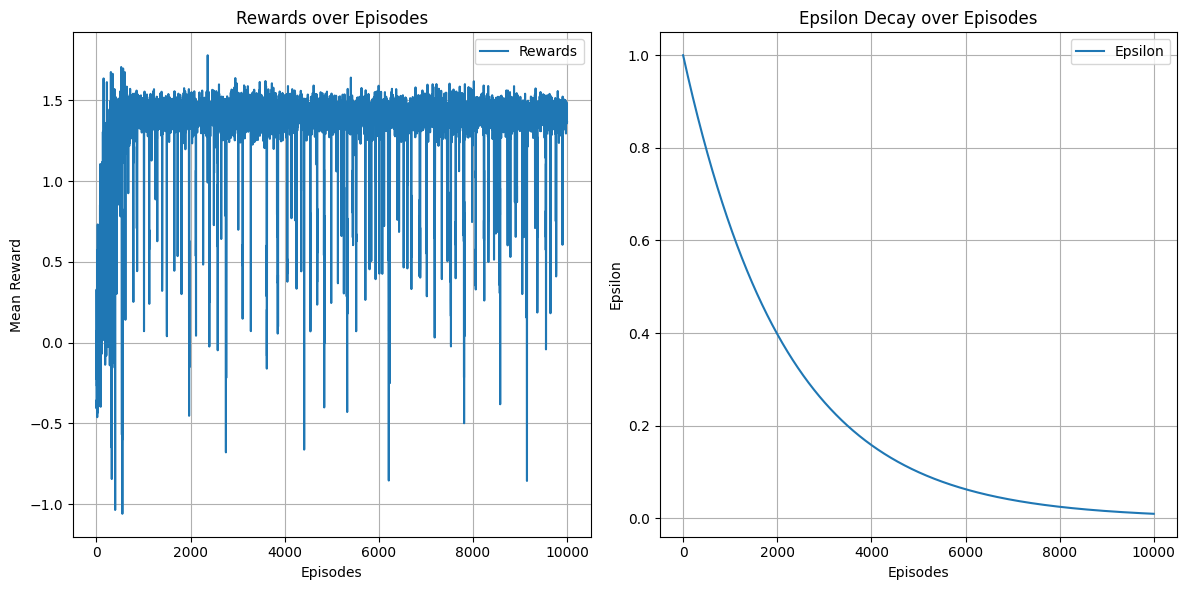

In [4]:
agent, reward_across_episodes, epsilons_across_episodes = q_learning_learning_loop(
    envs,
    agent,
    learning_rate=0.001,
    discount_factor=0.95,
    episodes=10000,
    min_epsilon_allowed=0.01,
    initial_epsilon_value=1,
    batch_size=128,
    decay_method="exponential",
    replay_frequency=4  # New parameter
)

#### Eval

In [11]:
total_rewards = run_learned_policy(envs, agent)
plot_grid(envs, agent, reward_across_episodes, epsilons_across_episodes)

ValueError: cannot reshape array of size 6 into shape (4,5)

#### Trained Agent

In [ ]:
from src.environment import StockTradingEnvironment

stock_trading_environment = StockTradingEnvironment('./AAPL_data.csv', number_of_days_to_consider=30)
stock_trading_environment.train = False
obs, _ = stock_trading_environment.reset()
terminated, truncated = False, False
while not terminated:
    obs_tuple = tuple(obs.flatten())
    action = np.argmax(agent.q_table1.get(obs_tuple, np.zeros(envs.action_space.n)) + agent.q_table2.get(obs_tuple, np.zeros(envs.action_space.n)))
    obs, reward, terminated, truncated, info = stock_trading_environment.step(action)

stock_trading_environment.render()

In [ ]:
save_pickle(agent, 'aapl_q_learning_agent.pkl')

#### Forecast

In [ ]:
agent = load_pickle("aapl_q_learning_agent.pkl")

In [ ]:
agent = load_pickle("aapl_q_learning_agent.pkl")

stock_trading_environment = make_env('AAPL_data.csv', number_of_days_to_consider=30)
stock_trading_environment.train = False
obs, _ = stock_trading_environment.reset()
terminated, truncated = False, False
while not terminated:
    obs_tuple = tuple(obs.flatten())
    action = np.argmax(agent.q_table1.get(obs_tuple, np.zeros(envs.action_space.n)) + agent.q_table2.get(obs_tuple, np.zeros(envs.action_space.n)))
    obs, reward, terminated, truncated, info = stock_trading_environment.step(action)

stock_trading_environment.render()